In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.models import load_model
from keras.layers import Dropout,Conv1D, MaxPooling1D, Flatten,TimeDistributed,Bidirectional
import math
import datetime as dt
from datetime import datetime    
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError


def import_data_from_csv(path: str):
    """
    Imports data from a csv file and returns a pandas dataframe.
    """
    return pd.read_csv(path)

def reshape_data(df):
    X = []
    Y = []
    window_size=100
    for i in range(1 , len(df) - window_size -1 , 1):
        first = df.iloc[i,4]
        temp = []
        temp2 = []
        for j in range(window_size):
            temp.append((df.iloc[i + j, 4] - first) / first)
        temp2.append((df.iloc[i + window_size, 4] - first) / first)
        X.append(np.array(temp).reshape(100, 1))
        Y.append(np.array(temp2).reshape(1, 1))
    return X,Y

def get_train_and_test_values(df):
    X,Y = reshape_data(df)
    train_X_values,test_X_values,train_Y_values,test_Y_values = [],[],[],[]
    
    num_splits = 5
    split_size = len(X) / num_splits
    
    X_splits = [X[int(i * split_size):int((i + 1) * split_size)] for i in range(num_splits)]
    Y_splits = [Y[int(i * split_size):int((i + 1) * split_size)] for i in range(num_splits)]
    
        
    for i in range(num_splits):
        x_train, x_test, y_train, y_test = train_test_split(X_splits[i], Y_splits[i], test_size=0.2, shuffle=True)
        train_X = np.array(x_train)
        test_X = np.array(x_test)
        train_Y = np.array(y_train)
        test_Y = np.array(y_test)
        
        train_X = train_X.reshape(train_X.shape[0],1,100,1)
        test_X = test_X.reshape(test_X.shape[0],1,100,1)
        
        train_X_values.append(train_X)
        test_X_values.append(test_X)
        train_Y_values.append(train_Y)
        test_Y_values.append(test_Y)

    return train_X_values,test_X_values,train_Y_values,test_Y_values

def create_model():
    model = tf.keras.Sequential()
    
    # Creating the Neural Network model here...
    # CNN layers
    model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 100, 1))))
    model.add(TimeDistributed(MaxPooling1D(2)))
    model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(2)))
    model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(2)))
    model.add(TimeDistributed(Flatten()))
    
    # LSTM layers
    model.add(Bidirectional(LSTM(100, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(100, return_sequences=False)))
    model.add(Dropout(0.5))
    
    #Final layers
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

    return model


def train_model(company_name,model,train_X_values,test_X_values,train_Y_values,test_Y_values):
    for i in range(len(train_X_values)):
        model.fit(train_X_values[i], train_Y_values[i], validation_data=(test_X_values[i],test_Y_values[i]), epochs=20,batch_size=40, verbose=1, shuffle =True)
        model.save("checkpoints/"+company_name+"/cnn-lstm-"+str(i+1)+".keras")
    return model

def get_test_X_and_test_Y_data(data2):
    data2.dropna(inplace=True)
    data2.reset_index(drop=True, inplace=True)
    df2 = data2.drop('Date', axis=1)
    
    X,Y = reshape_data(df2)
    
    test_X = np.array(X)
    test_Y = np.array(Y)
    
    test_X = test_X.reshape(test_X.shape[0],1,100,1)

    return test_X,test_Y

def evaluate_model(model,test_X,test_Y,data2):
    loss, mse, mae = model.evaluate(test_X, test_Y)
    print("Mean Squared Error (MSE):", mse)
    print("Mean Absolute Error (MAE):", mae)
    predicted = model.predict(test_X)
    test_label = test_Y.reshape(-1, 1)
    predicted = np.array(predicted[:, 0]).reshape(-1, 1)
    len_t = len(test_X)
    print("Number of test samples:", len_t)
    print("calculations")
    # Calculate MAE
    mae_sum = 0
    for j in range(len_t):
        mae_sum += abs(test_label[j] - predicted[j])
    mae = mae_sum / len_t
    print("Mean Absolute Error (MAE):", mae)

    # Calculate RMSE
    mse_sum = 0
    for j in range(len_t):
        mse_sum += (test_label[j] - predicted[j]) ** 2
    rmse = np.sqrt(mse_sum / len_t)
    print("Root Mean Squared Error (RMSE):", rmse)

    for j in range(len_t):
        temp = data2.iloc[j,3]
        test_label[j - len_t] = test_label[j - len_t] * temp + temp
        predicted[j - len_t] = predicted[j - len_t] * temp + temp
    plt.plot(test_label, color = 'red', label = 'Real Stock Price')
    plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
    plt.title(' Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(' Stock Price')
    plt.legend()
    plt.show()

def train_model_for_stocks(company_name):
    file_name = "..\\..\\data\\processed\\"
    file_name += company_name+'.csv'
    data = import_data_from_csv(file_name)
    train_X_values,test_X_values,train_Y_values,test_Y_values = get_train_and_test_values(data)
    model = create_model()
    model = train_model(company_name,model,train_X_values,test_X_values,train_Y_values,test_Y_values)
    return model
    

def main():
    # train_model_for_stocks("AAPL")
    # train_model_for_stocks("GOOG")
    # train_model_for_stocks("MSFT")
    # train_model_for_stocks("NFLX")
    # train_model_for_stocks("NVDA")
    # train_model_for_stocks("TSLA")
    pass

if __name__ == "__main__":
    main()

AAPL
Model 1:
20/20 [==============================] - 5s 8ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0293    
Mean Squared Error (MSE): 0.0013999717775732279
Mean Absolute Error (MAE): 0.029281923547387123
20/20 [==============================] - 3s 8ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.02928192]
Root Mean Squared Error (RMSE): [0.0374162]


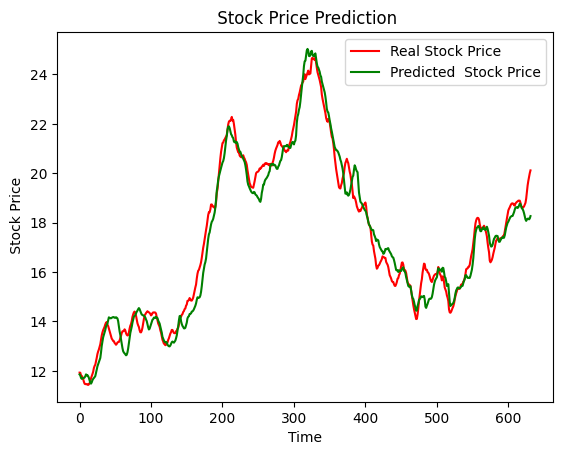

Model 2:
20/20 [==============================] - 5s 8ms/step - loss: 6.5863e-04 - mse: 6.5863e-04 - mae: 0.0204
Mean Squared Error (MSE): 0.0006586275994777679
Mean Absolute Error (MAE): 0.020402733236551285
20/20 [==============================] - 3s 8ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.02040273]
Root Mean Squared Error (RMSE): [0.02566374]


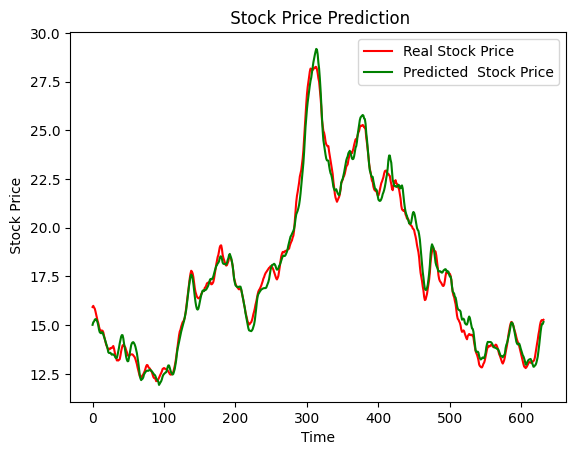

Model 3:
20/20 [==============================] - 7s 9ms/step - loss: 8.5152e-04 - mse: 8.5152e-04 - mae: 0.0228
Mean Squared Error (MSE): 0.0008515215013176203
Mean Absolute Error (MAE): 0.022798076272010803
20/20 [==============================] - 3s 10ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.02279808]
Root Mean Squared Error (RMSE): [0.02918084]


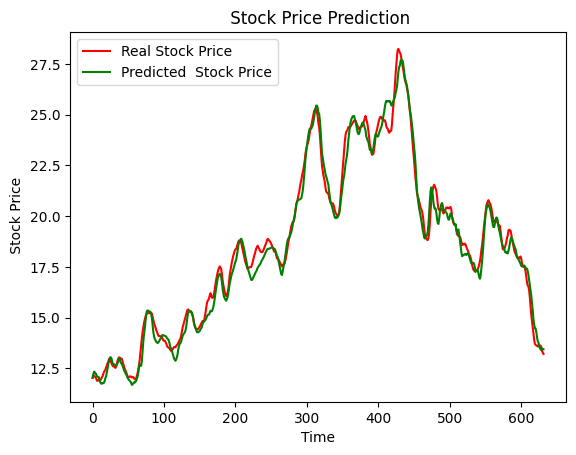

Model 4:
20/20 [==============================] - 5s 8ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0332    
Mean Squared Error (MSE): 0.0018053097883239388
Mean Absolute Error (MAE): 0.03315810486674309
20/20 [==============================] - 3s 8ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.03315811]
Root Mean Squared Error (RMSE): [0.04248894]


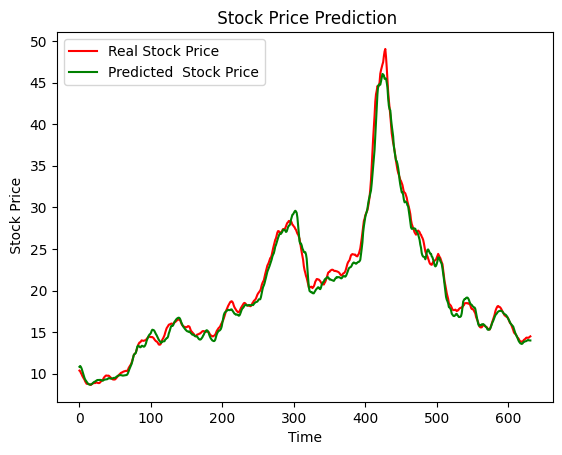

Model 5:
20/20 [==============================] - 5s 8ms/step - loss: 6.4812e-04 - mse: 6.4812e-04 - mae: 0.0207
Mean Squared Error (MSE): 0.0006481246091425419
Mean Absolute Error (MAE): 0.020680692046880722
20/20 [==============================] - 3s 7ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.02068069]
Root Mean Squared Error (RMSE): [0.02545829]


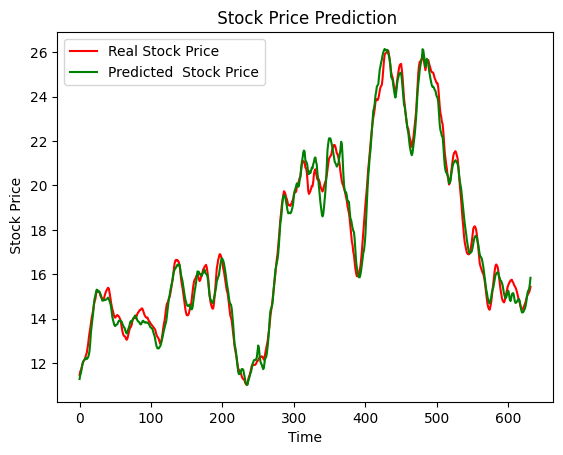

GOOG
Model 1:
20/20 [==============================] - 6s 8ms/step - loss: 7.8716e-04 - mse: 7.8716e-04 - mae: 0.0217
Mean Squared Error (MSE): 0.00078715814743191
Mean Absolute Error (MAE): 0.021715015172958374
20/20 [==============================] - 3s 8ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.02171502]
Root Mean Squared Error (RMSE): [0.02805634]


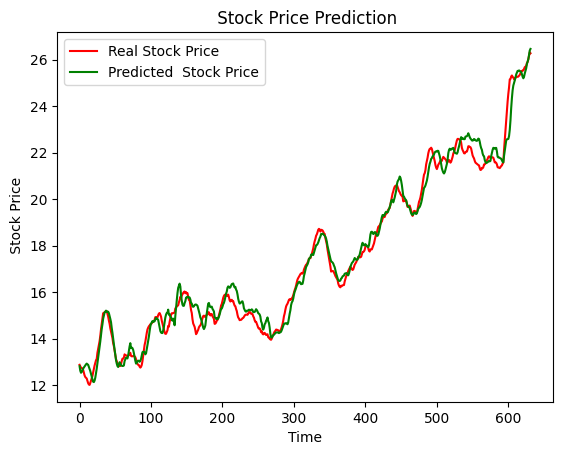

Model 2:
20/20 [==============================] - 6s 9ms/step - loss: 7.0306e-04 - mse: 7.0306e-04 - mae: 0.0193
Mean Squared Error (MSE): 0.0007030612323433161
Mean Absolute Error (MAE): 0.019323332235217094
20/20 [==============================] - 3s 8ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.01932333]
Root Mean Squared Error (RMSE): [0.0265153]


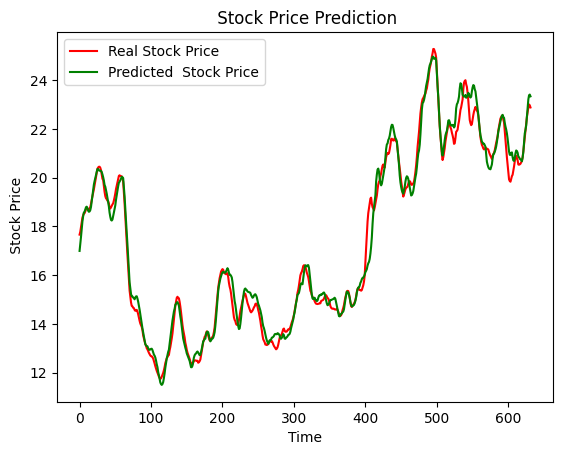

Model 3:
20/20 [==============================] - 5s 8ms/step - loss: 3.5273e-04 - mse: 3.5273e-04 - mae: 0.0145
Mean Squared Error (MSE): 0.0003527285298332572
Mean Absolute Error (MAE): 0.014518789015710354
20/20 [==============================] - 3s 8ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.01451879]
Root Mean Squared Error (RMSE): [0.01878107]


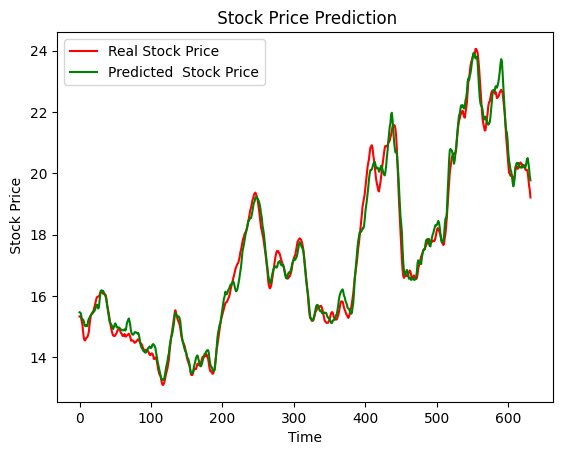

Model 4:
20/20 [==============================] - 6s 8ms/step - loss: 6.0804e-04 - mse: 6.0804e-04 - mae: 0.0183
Mean Squared Error (MSE): 0.000608044967520982
Mean Absolute Error (MAE): 0.018306253477931023
20/20 [==============================] - 3s 8ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.01830625]
Root Mean Squared Error (RMSE): [0.02465857]


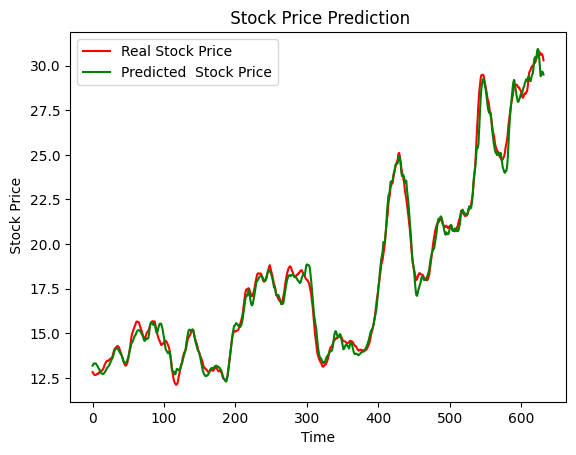

Model 5:
20/20 [==============================] - 6s 8ms/step - loss: 5.9976e-04 - mse: 5.9976e-04 - mae: 0.0183
Mean Squared Error (MSE): 0.0005997571861371398
Mean Absolute Error (MAE): 0.018327994272112846
20/20 [==============================] - 3s 8ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.01832799]
Root Mean Squared Error (RMSE): [0.02448994]


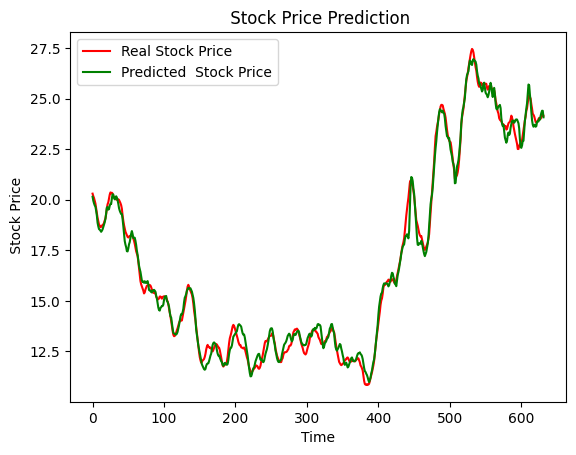

MSFT
Model 1:
20/20 [==============================] - 7s 9ms/step - loss: 7.1131e-04 - mse: 7.1131e-04 - mae: 0.0212
Mean Squared Error (MSE): 0.0007113148458302021
Mean Absolute Error (MAE): 0.021160876378417015
20/20 [==============================] - 3s 8ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.02116088]
Root Mean Squared Error (RMSE): [0.02667049]


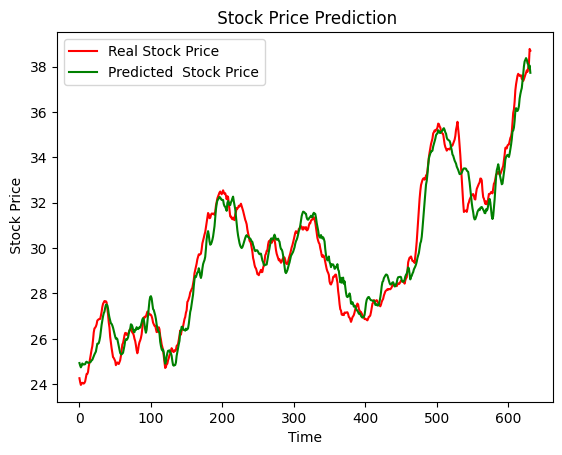

Model 2:
20/20 [==============================] - 5s 11ms/step - loss: 4.8731e-04 - mse: 4.8731e-04 - mae: 0.0183
Mean Squared Error (MSE): 0.00048730705748312175
Mean Absolute Error (MAE): 0.018314015120267868
20/20 [==============================] - 3s 9ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.01831401]
Root Mean Squared Error (RMSE): [0.02207503]


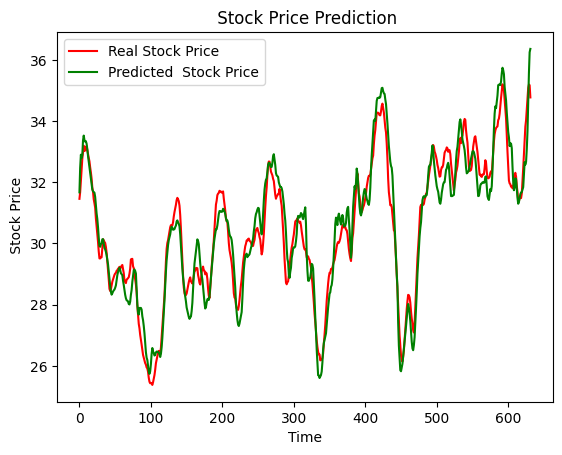

Model 3:
20/20 [==============================] - 6s 9ms/step - loss: 3.4433e-04 - mse: 3.4433e-04 - mae: 0.0144
Mean Squared Error (MSE): 0.00034433306427672505
Mean Absolute Error (MAE): 0.014420568011701107
20/20 [==============================] - 4s 9ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.01442057]
Root Mean Squared Error (RMSE): [0.01855621]


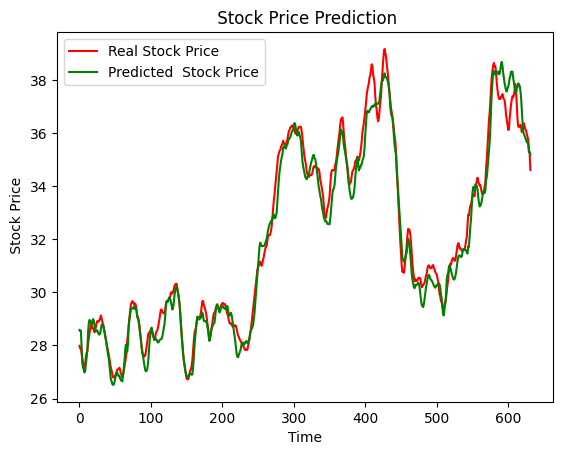

Model 4:
20/20 [==============================] - 6s 10ms/step - loss: 6.5366e-04 - mse: 6.5366e-04 - mae: 0.0193
Mean Squared Error (MSE): 0.0006536559667438269
Mean Absolute Error (MAE): 0.019260773435235023
20/20 [==============================] - 3s 8ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.01926077]
Root Mean Squared Error (RMSE): [0.0255667]


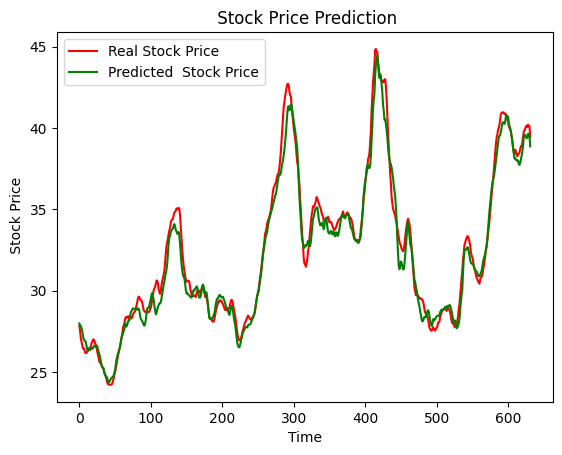

Model 5:
20/20 [==============================] - 7s 10ms/step - loss: 3.7778e-04 - mse: 3.7778e-04 - mae: 0.0153
Mean Squared Error (MSE): 0.0003777765086852014
Mean Absolute Error (MAE): 0.015306288376450539
20/20 [==============================] - 4s 9ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.01530629]
Root Mean Squared Error (RMSE): [0.01943647]


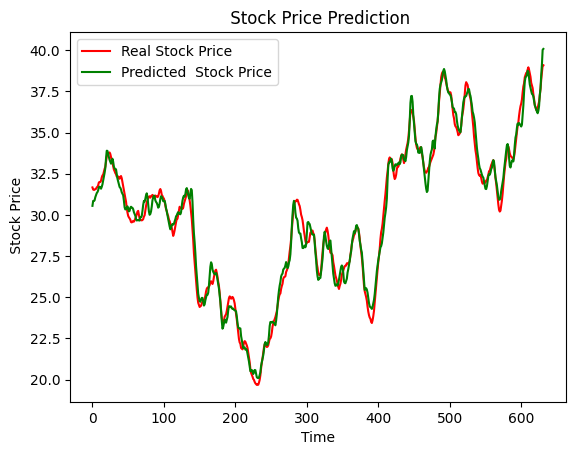

NFLX
Model 1:
20/20 [==============================] - 5s 8ms/step - loss: 0.0129 - mse: 0.0129 - mae: 0.0766
Mean Squared Error (MSE): 0.012872341088950634
Mean Absolute Error (MAE): 0.07663767784833908
20/20 [==============================] - 3s 8ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.07663768]
Root Mean Squared Error (RMSE): [0.11345634]


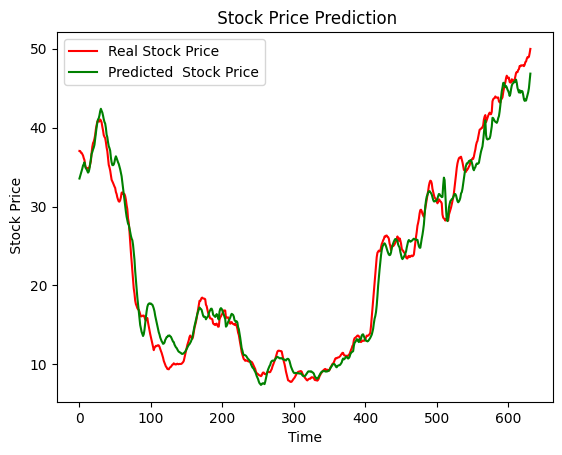

Model 2:
20/20 [==============================] - 6s 10ms/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0501
Mean Squared Error (MSE): 0.004100895952433348
Mean Absolute Error (MAE): 0.050135694444179535
20/20 [==============================] - 3s 10ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.0501357]
Root Mean Squared Error (RMSE): [0.06403824]


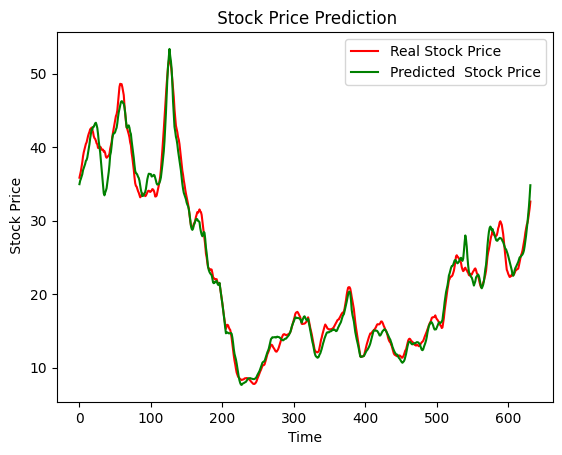

Model 3:
20/20 [==============================] - 6s 8ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0452
Mean Squared Error (MSE): 0.0036948188208043575
Mean Absolute Error (MAE): 0.04521328583359718
20/20 [==============================] - 3s 8ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.04521329]
Root Mean Squared Error (RMSE): [0.06078502]


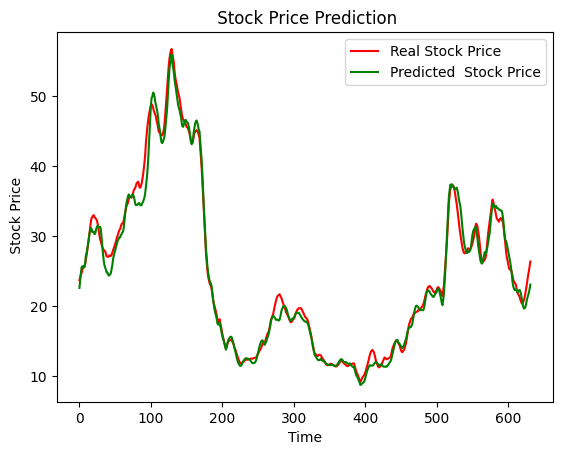

Model 4:
20/20 [==============================] - 5s 8ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0348
Mean Squared Error (MSE): 0.0021119648590683937
Mean Absolute Error (MAE): 0.03480302542448044
20/20 [==============================] - 3s 8ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.03480303]
Root Mean Squared Error (RMSE): [0.04595612]


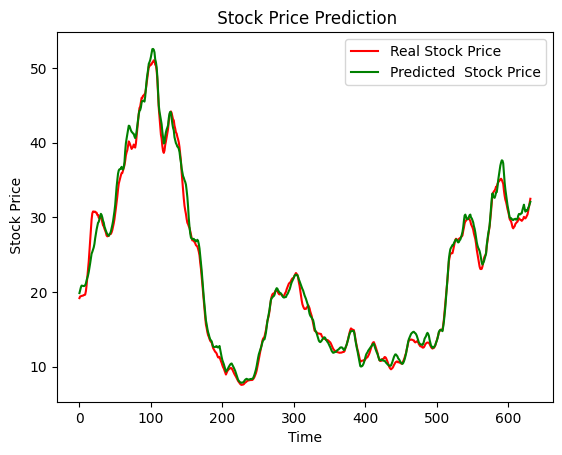

Model 5:
20/20 [==============================] - 6s 9ms/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0378   
Mean Squared Error (MSE): 0.002674806397408247
Mean Absolute Error (MAE): 0.03779048100113869
20/20 [==============================] - 3s 8ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.03779048]
Root Mean Squared Error (RMSE): [0.05171853]


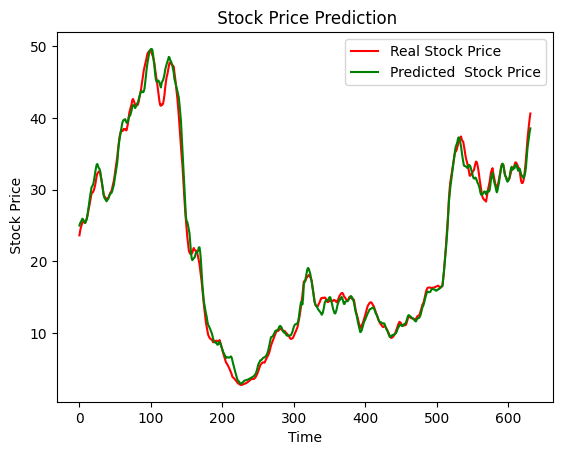

NVDA
Model 1:
20/20 [==============================] - 6s 9ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0265
Mean Squared Error (MSE): 0.0010562599636614323
Mean Absolute Error (MAE): 0.026479901745915413
20/20 [==============================] - 3s 8ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.0264799]
Root Mean Squared Error (RMSE): [0.03250015]


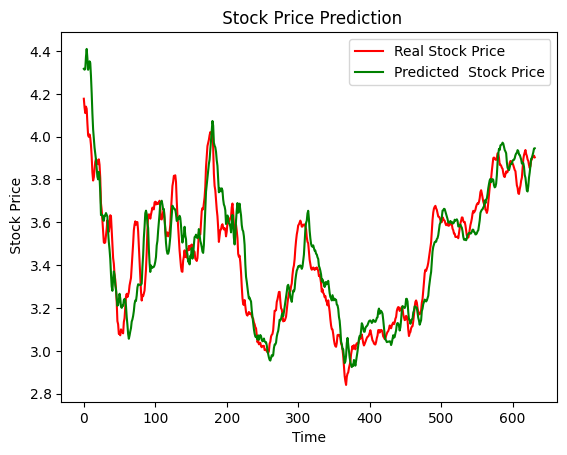

Model 2:
20/20 [==============================] - 6s 8ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0294    
Mean Squared Error (MSE): 0.0015702859964221716
Mean Absolute Error (MAE): 0.029392948374152184
20/20 [==============================] - 3s 9ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.02939295]
Root Mean Squared Error (RMSE): [0.03962683]


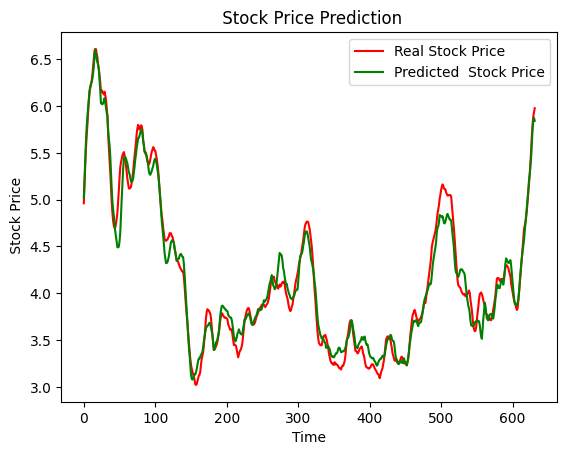

Model 3:
20/20 [==============================] - 6s 9ms/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0438
Mean Squared Error (MSE): 0.003239812795072794
Mean Absolute Error (MAE): 0.043836016207933426
20/20 [==============================] - 3s 8ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.04383601]
Root Mean Squared Error (RMSE): [0.05691935]


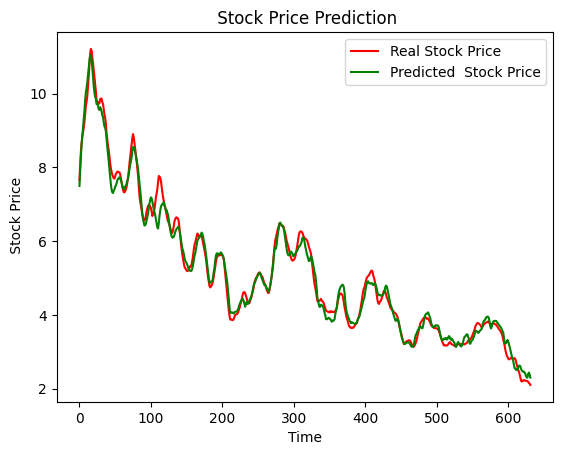

Model 4:
20/20 [==============================] - 7s 15ms/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0400
Mean Squared Error (MSE): 0.003186739981174469
Mean Absolute Error (MAE): 0.03998236730694771
20/20 [==============================] - 3s 10ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.03998237]
Root Mean Squared Error (RMSE): [0.05645122]


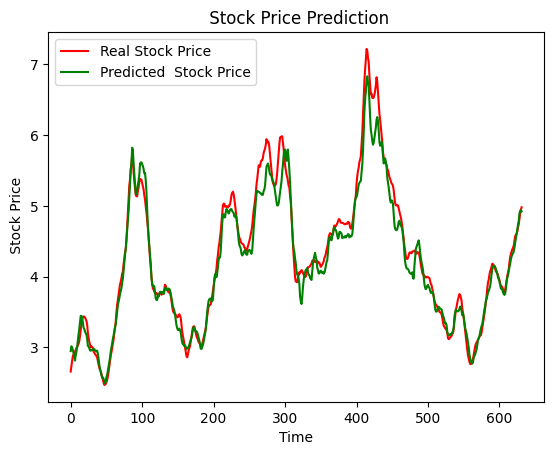

Model 5:
20/20 [==============================] - 5s 9ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0387
Mean Squared Error (MSE): 0.0022869149688631296
Mean Absolute Error (MAE): 0.038726672530174255
20/20 [==============================] - 3s 8ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.03872668]
Root Mean Squared Error (RMSE): [0.0478217]


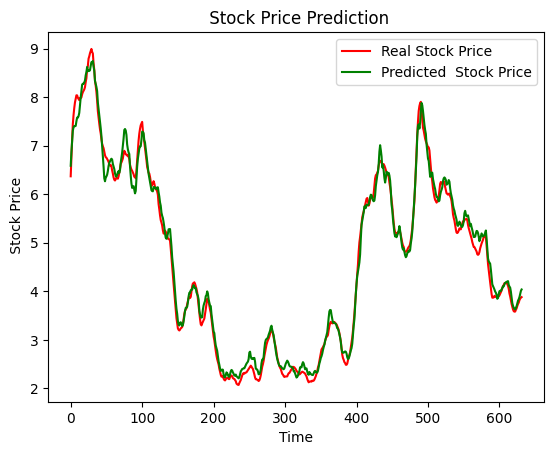

TSLA
Model 1:
20/20 [==============================] - 5s 8ms/step - loss: 0.0108 - mse: 0.0108 - mae: 0.0751
Mean Squared Error (MSE): 0.010775933973491192
Mean Absolute Error (MAE): 0.07508024573326111
20/20 [==============================] - 3s 8ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.07508025]
Root Mean Squared Error (RMSE): [0.1038072]


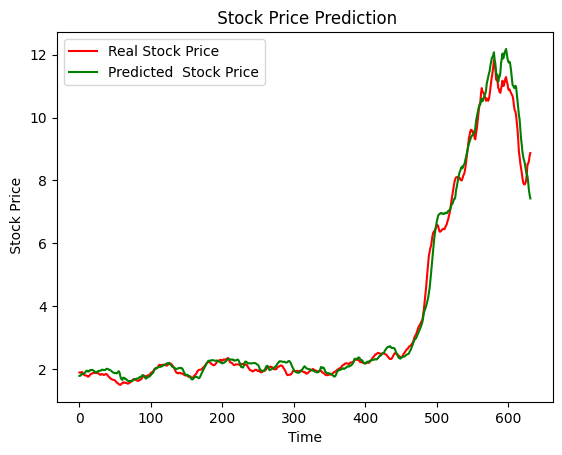

Model 2:
20/20 [==============================] - 6s 10ms/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0422
Mean Squared Error (MSE): 0.002844979288056493
Mean Absolute Error (MAE): 0.042169928550720215
20/20 [==============================] - 3s 8ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.04216993]
Root Mean Squared Error (RMSE): [0.05333835]


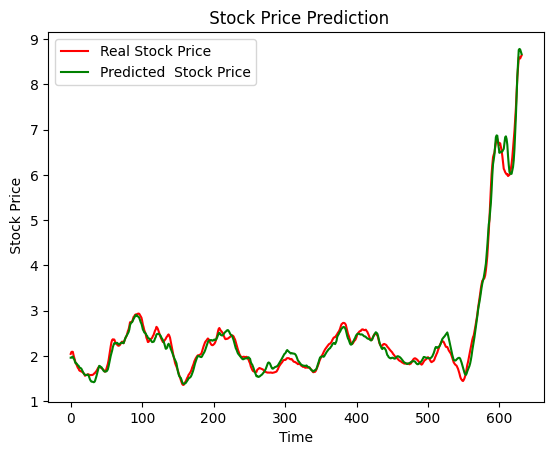

Model 3:
20/20 [==============================] - 5s 8ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0371
Mean Squared Error (MSE): 0.002212929306551814
Mean Absolute Error (MAE): 0.0370609350502491
20/20 [==============================] - 5s 8ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.03706094]
Root Mean Squared Error (RMSE): [0.04704178]


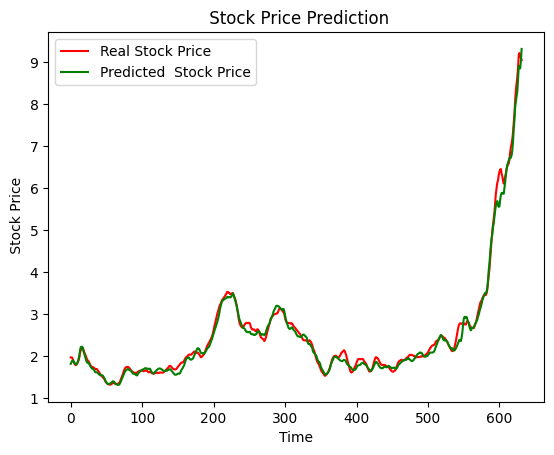

Model 4:
20/20 [==============================] - 6s 9ms/step - loss: 0.0207 - mse: 0.0207 - mae: 0.0975
Mean Squared Error (MSE): 0.02070963755249977
Mean Absolute Error (MAE): 0.09754268825054169
20/20 [==============================] - 3s 9ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.09754268]
Root Mean Squared Error (RMSE): [0.14390843]


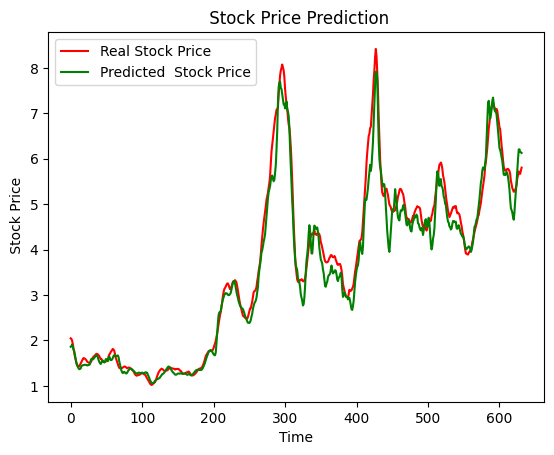

Model 5:
20/20 [==============================] - 5s 9ms/step - loss: 0.0030 - mse: 0.0030 - mae: 0.0416
Mean Squared Error (MSE): 0.0029847349505871534
Mean Absolute Error (MAE): 0.04160676524043083
20/20 [==============================] - 3s 8ms/step
Number of test samples: 632
calculations
Mean Absolute Error (MAE): [0.04160677]
Root Mean Squared Error (RMSE): [0.05463273]


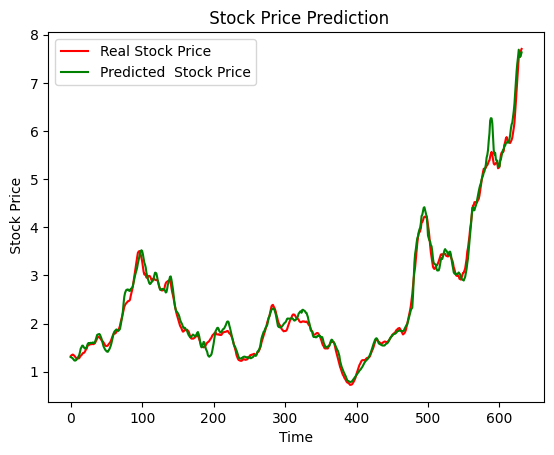

In [14]:
def load_saved_model(file_path):
    """
    Loads a saved Keras model from file.
    """
    return load_model(file_path)

def load_models(company_name):
    """
    Loads saved models for a given company.
    """
    models = []
    for i in range(1, 6):  # Assuming you saved 5 models for each company
        model_path = f"checkpoints/{company_name}/cnn-lstm-{i}.keras"
        model = load_saved_model(model_path)
        models.append(model)
    return models

def test_loaded_models(company_name):
    """
    Tests the loaded models for a given company.
    """
    data = import_data_from_csv(f"../../data/processed/{company_name}.csv")
    print(company_name)
    # print(data)
    test_X, test_Y = get_test_X_and_test_Y_data(data)
    models = load_models(company_name)
    for i, model in enumerate(models):
        print(f"Model {i+1}:")
        start_idx = int(len(test_X) * i / 5)
        end_idx = int(len(test_X) * (i + 1) / 5)
        evaluate_model(model, test_X[start_idx:end_idx], test_Y[start_idx:end_idx],data)


def test_models_for_stocks():
    """
    Tests the saved models for multiple stocks.
    """
    companies = ["AAPL", "GOOG", "MSFT", "NFLX", "NVDA", "TSLA"]
    for company in companies:
        test_loaded_models(company)


test_models_for_stocks()

AAPL
Model 1:
20/20 [==============================] - 3s 6ms/step
Model 2:
20/20 [==============================] - 2s 6ms/step
Model 3:
20/20 [==============================] - 2s 6ms/step
Model 4:
20/20 [==============================] - 2s 6ms/step
Model 5:
20/20 [==============================] - 2s 6ms/step
3160


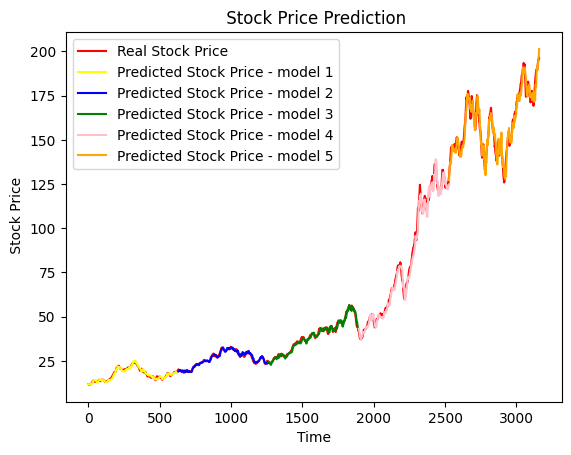

GOOG
Model 1:
20/20 [==============================] - 3s 7ms/step
Model 2:
20/20 [==============================] - 2s 7ms/step
Model 3:
20/20 [==============================] - 3s 7ms/step
Model 4:
20/20 [==============================] - 3s 7ms/step
Model 5:
20/20 [==============================] - 3s 8ms/step
3160


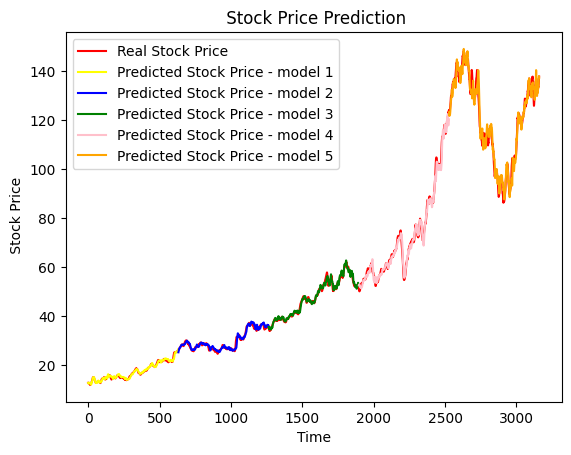

MSFT
Model 1:
20/20 [==============================] - 2s 6ms/step
Model 2:
20/20 [==============================] - 2s 6ms/step
Model 3:
20/20 [==============================] - 2s 7ms/step
Model 4:
20/20 [==============================] - 3s 7ms/step
Model 5:
20/20 [==============================] - 3s 7ms/step
3160


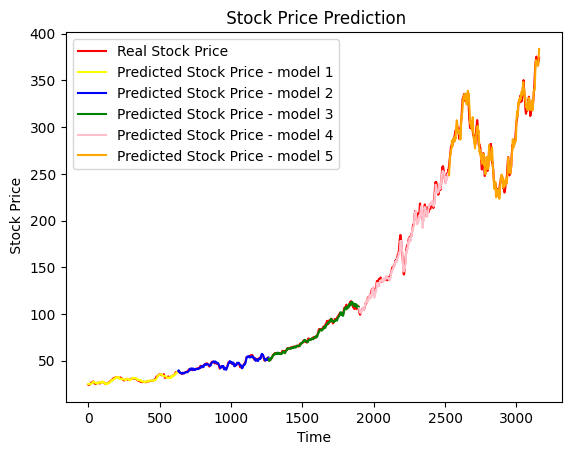

NFLX
Model 1:
20/20 [==============================] - 2s 6ms/step
Model 2:
20/20 [==============================] - 2s 6ms/step
Model 3:
20/20 [==============================] - 2s 6ms/step
Model 4:
20/20 [==============================] - 2s 6ms/step
Model 5:
20/20 [==============================] - 3s 7ms/step
3160


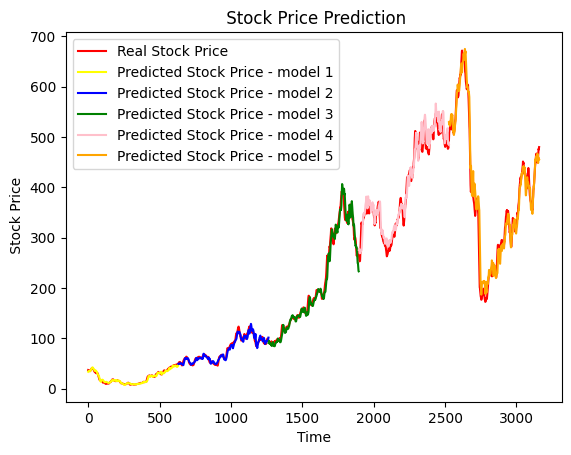

NVDA
Model 1:
20/20 [==============================] - 3s 7ms/step
Model 2:
20/20 [==============================] - 3s 7ms/step
Model 3:
20/20 [==============================] - 3s 7ms/step
Model 4:
20/20 [==============================] - 3s 10ms/step
Model 5:
20/20 [==============================] - 3s 7ms/step
3160


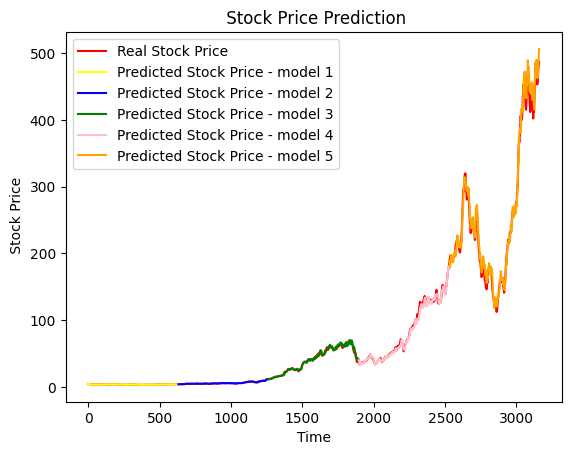

TSLA
Model 1:
20/20 [==============================] - 2s 6ms/step
Model 2:
20/20 [==============================] - 2s 6ms/step
Model 3:
20/20 [==============================] - 2s 6ms/step
Model 4:
20/20 [==============================] - 3s 8ms/step
Model 5:
20/20 [==============================] - 3s 7ms/step
3160


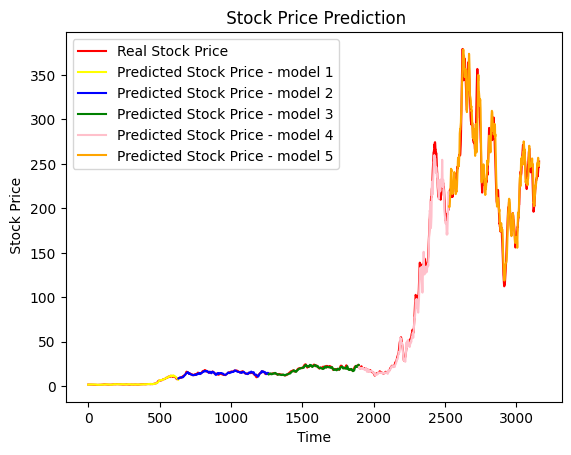

In [28]:

def draw_model(company_name):
    """
    Tests the loaded models for a given company.
    """
    data = import_data_from_csv(f"../../data/processed/{company_name}.csv")
    print(company_name)
    # print(data)
    test_X, test_Y = get_test_X_and_test_Y_data(data)
    
    models = load_models(company_name)
    predictions = []
    for i, model in enumerate(models):
        print(f"Model {i+1}:")
        start_idx = int(len(test_X) * i / 5)
        end_idx = int(len(test_X) * (i + 1) / 5)
        
        predicted = model.predict(test_X[start_idx:end_idx])
        predicted = np.array(predicted[:, 0]).reshape(-1, 1)
        predictions.append(predicted)

    test_label = test_Y.reshape(-1, 1)
    len_t = len(test_X)
    
    print(len_t)
    for j in range(len_t):
        temp = data.iloc[j,3]
        test_label[j - len_t] = test_label[j - len_t] * temp + temp
    len_tt = len_t//5
    for j in range(len_tt):
        temp = data.iloc[j,3]
        temp2 = data.iloc[j+len_tt,3]
        temp3 = data.iloc[j+len_tt*2,3]
        temp4 = data.iloc[j+len_tt*3,3]
        temp5 = data.iloc[j+len_tt*4,3]
        predictions[0][j - len_tt] = predictions[0][j - len_tt] * temp + temp
        predictions[1][j - len_tt] = predictions[1][j - len_tt] * temp2 + temp2
        predictions[2][j - len_tt] = predictions[2][j - len_tt] * temp3 + temp3
        predictions[3][j - len_tt] = predictions[3][j - len_tt] * temp4 + temp4
        predictions[4][j - len_tt] = predictions[4][j - len_tt] * temp5 + temp5
        
    shift_amount = len_t // 5  # Assuming 5 models

    plt.plot(test_label, color='red', label='Real Stock Price')

    # Plotting the predictions for each model, shifted accordingly
    colors= ["yellow","blue","green","pink","orange"]
    plt.plot(range(0 * shift_amount, 0 * shift_amount + len(predictions[0])), predictions[0], label=f'Predicted Stock Price - model {0 + 1}',color=colors[0])
    plt.plot(range(1 * shift_amount, 1 * shift_amount + len(predictions[1])), predictions[1], label=f'Predicted Stock Price - model {1 + 1}',color=colors[1])
    plt.plot(range(2 * shift_amount, 2 * shift_amount + len(predictions[2])), predictions[2], label=f'Predicted Stock Price - model {2 + 1}',color=colors[2])
    plt.plot(range(3 * shift_amount, 3 * shift_amount + len(predictions[3])), predictions[3], label=f'Predicted Stock Price - model {3 + 1}',color=colors[3])
    plt.plot(range(4 * shift_amount, 4 * shift_amount + len(predictions[4])), predictions[4], label=f'Predicted Stock Price - model {4 + 1}',color=colors[4])

    plt.title(' Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(' Stock Price')
    plt.legend()
    plt.show()

companies = ["AAPL", "GOOG", "MSFT", "NFLX", "NVDA", "TSLA"]
for company in companies:
    draw_model(company)
